# LSTM prediction

## Access the file in Google Drive

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Get to the folder we are at
FOLDERNAME = 'Colab\ Notebooks/Quantitative_trading_project/15min_data_prediction'
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Quantitative_trading_project/15min_data_prediction


In [2]:
# Define device
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)

Device: cpu


## Import Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

## Data Pre-processing

In [4]:
# Load data
btc_spot = pd.read_csv('data/btc_usdt_spot_data.csv')
btc_futures = pd.read_csv('data/btc_usdt_futures_data.csv')
indicators = pd.read_csv('data/indicators.csv')
true_label = pd.read_csv('data/period_labels.csv')

In [5]:
btc_spot.head()
# print(btc_spot.columns)

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2021-01-01 00:00:00,28923.63,29017.50,28690.17,28752.80,840.077569,1.609460e+12,2.423972e+07,19318.0,393.704224,1.136006e+07,0.0
1,2021-01-01 00:15:00,28752.80,28875.55,28720.91,28836.63,480.611179,1.609461e+12,1.384695e+07,13876.0,235.967978,6.798117e+06,0.0
2,2021-01-01 00:30:00,28836.63,28943.87,28836.62,28930.11,471.134708,1.609462e+12,1.361619e+07,12234.0,307.966715,8.899807e+06,0.0
3,2021-01-01 00:45:00,28930.11,29031.34,28889.99,28995.13,519.987989,1.609463e+12,1.506597e+07,12961.0,277.720321,8.045564e+06,0.0
4,2021-01-01 01:00:00,28995.13,29385.00,28960.35,29382.59,1735.839005,1.609464e+12,5.068079e+07,32696.0,1152.696972,3.366289e+07,0.0


In [6]:
# Drop unnecessary columns
columns_to_drop = ['close_time', 'ignore']
btc_spot.drop(columns=columns_to_drop, inplace=True)
btc_futures.drop(columns=columns_to_drop, inplace=True)

In [7]:
# btc_spot.head()
# print(btc_spot.columns)

In [8]:
# Set timestamp as index and convert to datetime
btc_spot['timestamp'] = pd.to_datetime(btc_spot['timestamp'])
btc_spot.set_index('timestamp', inplace=True)
btc_futures['timestamp'] = pd.to_datetime(btc_futures['timestamp'])
btc_futures.set_index('timestamp', inplace=True)
indicators['timestamp'] = pd.to_datetime(indicators['timestamp'])
indicators.set_index('timestamp', inplace=True)
true_label['time'] = pd.to_datetime(true_label['time'])
true_label.set_index('time', inplace=True)

In [9]:
def rename_col(df, name):
  for column in df.columns:
    df.rename(columns={column: f'{name}_{column}'}, inplace=True)
  return df

In [10]:
btc_spot = rename_col(btc_spot, 'btc_spot')
btc_futures = rename_col(btc_futures, 'btc_futures')

In [11]:
# shift because we aim to predict the label for next K bar
true_label = true_label.shift(-1)

# Merge DataFrames on the timestamp index
df = pd.concat([true_label, btc_spot, btc_futures, indicators], axis=1)
df.head()

,label,btc_spot_open,btc_spot_high,btc_spot_low,btc_spot_close,btc_spot_volume,btc_spot_quote_asset_volume,btc_spot_number_of_trades,btc_spot_taker_buy_base_asset_volume,btc_spot_taker_buy_quote_asset_volume,...,obv,cmf,williams,parabolic_sar,vwap,fibonacci_0.236,fibonacci_0.382,fibonacci_0.5,fibonacci_0.618,fibonacci_0.764
2021-01-01 00:00:00,NaN,28923.63,29017.50,28690.17,28752.80,840.077569,2.423972e+07,19318.0,393.704224,1.136006e+07,...,3181.960,NaN,NaN,28786.75,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:15:00,NaN,28752.80,28875.55,28720.91,28836.63,480.611179,1.384695e+07,13876.0,235.967978,6.798117e+06,...,5397.275,NaN,NaN,28859.28,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:30:00,NaN,28836.63,28943.87,28836.62,28930.11,471.134708,1.361619e+07,12234.0,307.966715,8.899807e+06,...,6550.953,NaN,NaN,29045.93,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:45:00,NaN,28930.11,29031.34,28889.99,28995.13,519.987989,1.506597e+07,12961.0,277.720321,8.045564e+06,...,8037.588,NaN,NaN,28859.99,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,NaN,28995.13,29385.00,28960.35,29382.59,1735.839005,5.068079e+07,32696.0,1152.696972,3.366289e+07,...,15513.655,NaN,NaN,28859.99,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.shape

(121057, 47)

In [13]:
# Number of previous K lines to include
num_k_line = 24  # 6 hr

# Create a list to hold the lagged DataFrames
lagged_data = []

# Add the original columns with a suffix indicating the lag (0 for the original values)
for i in range(1, num_k_line + 1):
    lagged_df = df.drop(columns='label').shift(i).add_suffix(f'_lag_{i}')
    lagged_data.append(lagged_df)

# Concatenate all the lagged DataFrames along the columns
df_lagged = pd.concat(lagged_data, axis=1)
df = pd.concat([df, df_lagged], axis=1)

# Drop rows with any NaN values (since the first `n_hours` rows will have NaNs)
df.dropna(inplace=True)

In [14]:
df

,label,btc_spot_open,btc_spot_high,btc_spot_low,btc_spot_close,btc_spot_volume,btc_spot_quote_asset_volume,btc_spot_number_of_trades,btc_spot_taker_buy_base_asset_volume,btc_spot_taker_buy_quote_asset_volume,...,obv_lag_24,cmf_lag_24,williams_lag_24,parabolic_sar_lag_24,vwap_lag_24,fibonacci_0.236_lag_24,fibonacci_0.382_lag_24,fibonacci_0.5_lag_24,fibonacci_0.618_lag_24,fibonacci_0.764_lag_24
2021-01-02 06:00:00,1.0,29589.99,29647.50,29450.00,29640.65,823.280290,2.434791e+07,15640.0,604.785858,1.789109e+07,...,12171.239,0.144378,-10.794473,29350.000000,29262.331413,29423.00936,29270.91532,29147.99,29025.06468,28872.97064
2021-01-02 06:15:00,1.0,29640.65,29663.10,29547.83,29659.47,553.565606,1.638788e+07,14616.0,293.560533,8.691268e+06,...,6618.274,0.034077,-76.868491,29350.000000,29218.538466,29423.00936,29270.91532,29147.99,29025.06468,28872.97064
2021-01-02 06:30:00,1.0,29659.47,29676.58,29537.11,29598.46,536.400632,1.588963e+07,11769.0,311.656935,9.233140e+06,...,9165.088,0.098525,-35.195017,29350.000000,29209.187468,29423.00936,29270.91532,29147.99,29025.06468,28872.97064
2021-01-02 06:45:00,1.0,29598.46,29745.00,29593.58,29709.07,1116.994292,3.316573e+07,19088.0,709.613955,2.106894e+07,...,10636.363,0.155942,-34.232693,29334.329600,29207.598774,29423.00936,29270.91532,29147.99,29025.06468,28872.97064
2021-01-02 07:00:00,1.0,29709.06,29768.10,29675.82,29764.91,1058.048256,3.146510e+07,15744.0,785.838396,2.337269e+07,...,9542.650,0.017322,-55.934756,29319.286016,29201.787770,29423.00936,29270.91532,29147.99,29025.06468,28872.97064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-08 22:45:00,1.0,69334.47,69347.72,69309.97,69338.15,54.464150,3.776257e+06,4059.0,28.951720,2.007373e+06,...,-3459612.827,0.170731,-32.010354,69333.094749,69423.454444,70327.45320,69960.07340,69663.15,69366.22660,68998.84680
2024-06-08 23:00:00,1.0,69338.15,69340.00,69314.01,69325.70,60.798060,4.215020e+06,4539.0,25.189390,1.746258e+06,...,-3459149.524,0.129270,-29.683698,69345.509064,69440.068357,70161.43600,69825.78200,69554.50,69283.21800,68947.56400
2024-06-08 23:15:00,1.0,69325.70,69325.71,69293.54,69303.38,58.806180,4.075849e+06,3776.0,24.722120,1.713447e+06,...,-3459712.618,0.118378,-50.024331,69357.178521,69441.935930,70062.34520,69745.62740,69489.65,69233.67260,68916.95480
2024-06-08 23:30:00,1.0,69303.37,69335.13,69292.99,69335.13,73.237270,5.076107e+06,4346.0,47.302560,3.278662e+06,...,-3459097.911,0.162260,-21.459854,69368.147809,69444.293887,69955.30880,69659.04560,69419.60,69180.15440,68883.89120


In [15]:
df.shape

(112135, 1151)

In [16]:
# Split data into training and testing sets by date 2023-06-30
training_data = df.loc[df.index <= '2023-06-30']
testing_data = df.loc[df.index > '2023-06-30']

# Print shapes to verify the split
print(f'Training data shape: {training_data.shape}')
print(f'Testing data shape: {testing_data.shape}')

Training data shape: (80939, 1151)
Testing data shape: (31196, 1151)


In [17]:
print(training_data)
print(testing_data)

                     label  btc_spot_open  btc_spot_high  btc_spot_low  \
2021-01-02 06:00:00    1.0       29589.99       29647.50      29450.00   
2021-01-02 06:15:00    1.0       29640.65       29663.10      29547.83   
2021-01-02 06:30:00    1.0       29659.47       29676.58      29537.11   
2021-01-02 06:45:00    1.0       29598.46       29745.00      29593.58   
2021-01-02 07:00:00    1.0       29709.06       29768.10      29675.82   
...                    ...            ...            ...           ...   
2023-06-29 23:00:00    1.0       30409.35       30418.00      30392.78   
2023-06-29 23:15:00    1.0       30405.18       30485.08      30396.01   
2023-06-29 23:30:00    1.0       30482.19       30526.42      30474.06   
2023-06-29 23:45:00    1.0       30480.00       30480.00      30444.01   
2023-06-30 00:00:00    1.0       30447.31       30474.57      30421.53   

                     btc_spot_close  btc_spot_volume  \
2021-01-02 06:00:00        29640.65       823.280290   

In [18]:
# Normalize the dataset
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
testing_data = scaler.transform(testing_data)

training_data

array([[1.        , 0.26383976, 0.2638687 , ..., 0.25764243, 0.25815469,
        0.25856496],
       [1.        , 0.26479847, 0.26416409, ..., 0.25764243, 0.25815469,
        0.25856496],
       [1.        , 0.26515463, 0.26441933, ..., 0.25764243, 0.25815469,
        0.25856496],
       ...,
       [1.        , 0.28072413, 0.28051106, ..., 0.28032943, 0.28096271,
        0.2815038 ],
       [1.        , 0.28068269, 0.27963209, ..., 0.28032943, 0.28096271,
        0.2815038 ],
       [1.        , 0.28006405, 0.27952928, ..., 0.28032943, 0.28096271,
        0.2815038 ]])

### Prepared data for LSTM model

In [19]:
# Remove the first column (true labels)
X_train = training_data[:, 1:]
y_train = training_data[:, 0]
X_test = testing_data[:, 1:]
y_test = testing_data[:, 0]

# Reshape to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], 25, -1)
y_train = y_train.reshape(y_train.shape[0], 1)
X_test = X_test.reshape(X_test.shape[0], 25, -1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [20]:
print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)
print(X_test)
print(X_test.shape)
print(y_test)
print(y_test.shape)

[[[0.26383976 0.2638687  0.26479129 ... 0.25794362 0.25838581 0.2587084 ]
  [0.26141882 0.26217232 0.26537094 ... 0.25764243 0.25815469 0.25856496]
  [0.26134276 0.26141667 0.26400679 ... 0.25764243 0.25815469 0.25856496]
  ...
  [0.25219227 0.25306748 0.25472587 ... 0.25764243 0.25815469 0.25856496]
  [0.25741719 0.25517058 0.25414176 ... 0.25764243 0.25815469 0.25856496]
  [0.25783493 0.25571592 0.25890914 ... 0.25764243 0.25815469 0.25856496]]

 [[0.26479847 0.26416409 0.26664505 ... 0.25813706 0.25853425 0.25880053]
  [0.26311716 0.26325857 0.26469679 ... 0.25794362 0.25838581 0.2587084 ]
  [0.26141882 0.26217232 0.26445568 ... 0.25764243 0.25815469 0.25856496]
  ...
  [0.25515737 0.2532026  0.25755792 ... 0.25764243 0.25815469 0.25856496]
  [0.25219227 0.25306748 0.25472587 ... 0.25764243 0.25815469 0.25856496]
  [0.25741719 0.25517058 0.25414176 ... 0.25764243 0.25815469 0.25856496]]

 [[0.26515463 0.26441933 0.26644192 ... 0.25813706 0.25853425 0.25880053]
  [0.26407325 0.263553

In [21]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train)
print(X_train.shape)

tensor([[[0.2638, 0.2639, 0.2648,  ..., 0.2579, 0.2584, 0.2587],
         [0.2614, 0.2622, 0.2654,  ..., 0.2576, 0.2582, 0.2586],
         [0.2613, 0.2614, 0.2640,  ..., 0.2576, 0.2582, 0.2586],
         ...,
         [0.2522, 0.2531, 0.2547,  ..., 0.2576, 0.2582, 0.2586],
         [0.2574, 0.2552, 0.2541,  ..., 0.2576, 0.2582, 0.2586],
         [0.2578, 0.2557, 0.2589,  ..., 0.2576, 0.2582, 0.2586]],

        [[0.2648, 0.2642, 0.2666,  ..., 0.2581, 0.2585, 0.2588],
         [0.2631, 0.2633, 0.2647,  ..., 0.2579, 0.2584, 0.2587],
         [0.2614, 0.2622, 0.2645,  ..., 0.2576, 0.2582, 0.2586],
         ...,
         [0.2552, 0.2532, 0.2576,  ..., 0.2576, 0.2582, 0.2586],
         [0.2522, 0.2531, 0.2547,  ..., 0.2576, 0.2582, 0.2586],
         [0.2574, 0.2552, 0.2541,  ..., 0.2576, 0.2582, 0.2586]],

        [[0.2652, 0.2644, 0.2664,  ..., 0.2581, 0.2585, 0.2588],
         [0.2641, 0.2636, 0.2665,  ..., 0.2581, 0.2585, 0.2588],
         [0.2631, 0.2633, 0.2638,  ..., 0.2579, 0.2584, 0.

In [22]:
# Create DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [23]:
one_train = next(iter(train_loader))
print(one_train[0].shape)
print(one_train[1].shape)

torch.Size([32, 25, 46])
torch.Size([32, 1])


## Build LSTM Model

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.drop_out = nn.Dropout(p=0.5)
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.drop_out(out)
        linear_out = self.linear(out)
        predictions = self.sigmoid(linear_out)  # Apply sigmoid activation
        return predictions

In [25]:
# hyperparameters
input_size = X_train.shape[2]
hidden_layer_size = 128
output_size = 1 # Binary classification
learning_rate = 0.001

In [26]:
# Initialize model and move it to the GPU
model = LSTM(input_size, hidden_layer_size, output_size).to(device)
loss_function = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training & Testing

In [27]:
# recording losses and accuracies for each epoch
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [28]:
epochs = 50

# Training model
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

        # Calculate accuracy
        predicted = (y_pred > 0.5).float()
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    predictions = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            test_loss += loss.item()

            # Calculate accuracy
            predicted = (y_pred >= 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]}, Testing Loss: {test_losses[-1]}, Training Accuracy: {train_accuracy}%, Testing Accuracy: {test_accuracy}%')

Epoch 1/50, Training Loss: 0.6688024881697101, Testing Loss: 0.6577509376635918, Training Accuracy: 64.24467809090797%, Testing Accuracy: 63.37992050262854%
Epoch 2/50, Training Loss: 0.6575316897258457, Testing Loss: 0.6598510896548246, Training Accuracy: 64.3200434895415%, Testing Accuracy: 63.37992050262854%
Epoch 3/50, Training Loss: 0.6552645198205714, Testing Loss: 0.6605429252600058, Training Accuracy: 64.3200434895415%, Testing Accuracy: 63.37992050262854%
Epoch 4/50, Training Loss: 0.6540528629078224, Testing Loss: 0.6603737697845851, Training Accuracy: 64.3200434895415%, Testing Accuracy: 63.37992050262854%
Epoch 5/50, Training Loss: 0.6536912449852751, Testing Loss: 0.6604794800892855, Training Accuracy: 64.3200434895415%, Testing Accuracy: 63.37992050262854%
Epoch 6/50, Training Loss: 0.6533482846181854, Testing Loss: 0.6600406323029445, Training Accuracy: 64.3200434895415%, Testing Accuracy: 63.37992050262854%
Epoch 7/50, Training Loss: 0.6542220726785923, Testing Loss: 0.

### Visualize data

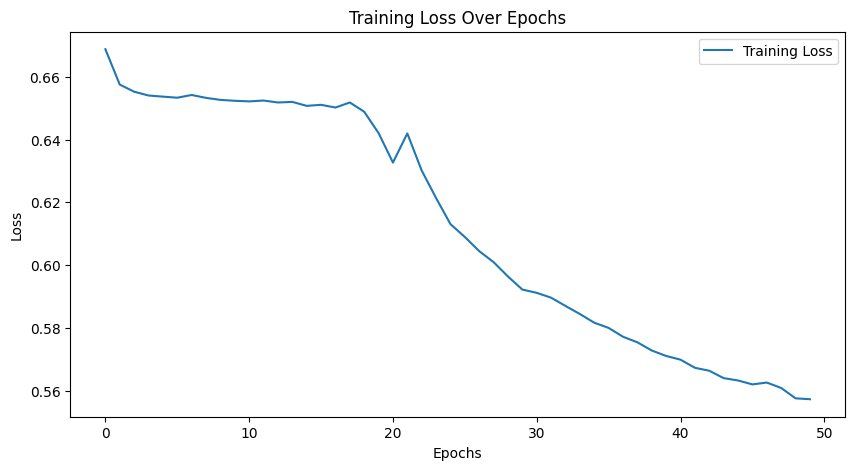

In [35]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

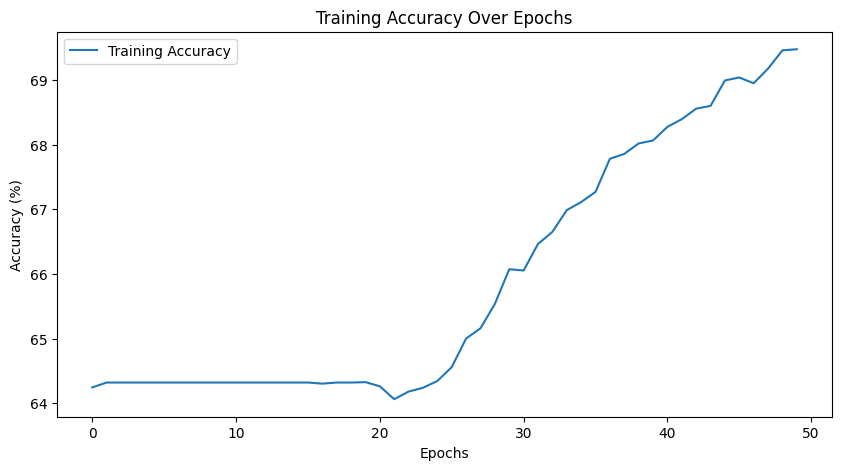

In [30]:
# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

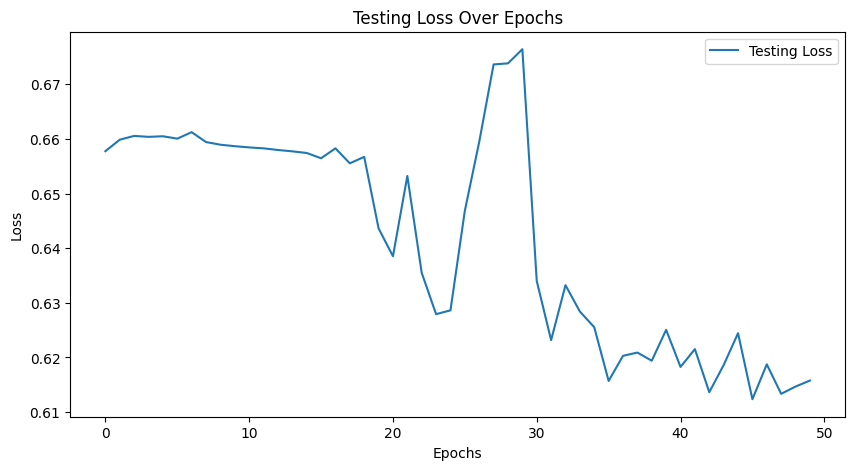

In [31]:
# Plotting the testing loss
plt.figure(figsize=(10, 5))
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Loss Over Epochs')
plt.legend()
plt.show()

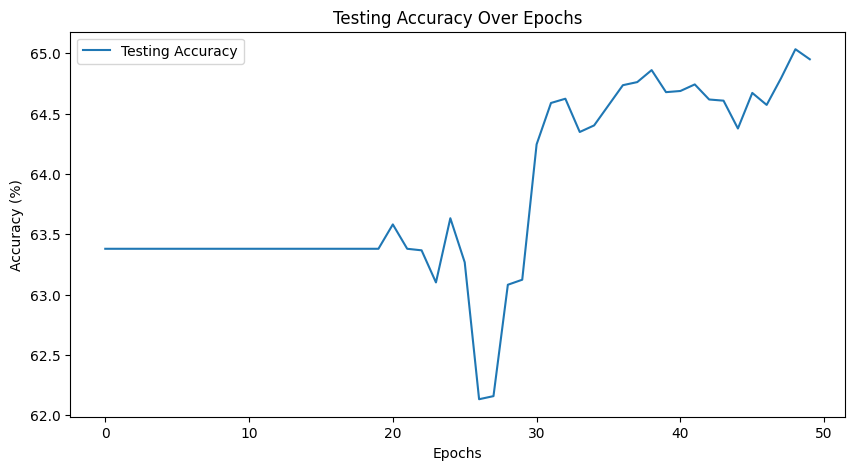

In [32]:
# Plotting the testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy Over Epochs')
plt.legend()
plt.show()

## Output result

In [49]:
# Save testing results to CSV
df_pred = pd.DataFrame({'prediction': predictions})
df_pred = df_pred['prediction'].apply(lambda x: x[0])
df_pred.index = df.loc[df.index > '2023-06-30'].index
df_pred

2023-06-30 00:15:00    0.0
2023-06-30 00:30:00    0.0
2023-06-30 00:45:00    0.0
2023-06-30 01:00:00    0.0
2023-06-30 01:15:00    0.0
                      ... 
2024-06-08 22:45:00    1.0
2024-06-08 23:00:00    1.0
2024-06-08 23:15:00    1.0
2024-06-08 23:30:00    1.0
2024-06-08 23:45:00    1.0
Name: prediction, Length: 31196, dtype: float32

In [50]:
df_pred.to_csv('data/testing_results.csv', index=True)
print('Testing results saved to data/testing_results.csv')

Testing results saved to data/testing_results.csv
